---
Fine Tuning Social Media Based Firm Embeddings
                        Dili Maduabum

---

This notebook walks through the pipeline for collecting, cleaning, and analyzing Reddit data to understand how companies are discussed in online forums like r/stocks and r/wallstreetbets.

**Goal**: To extract meaningful company-related discussions from Reddit, build structured datasets, and eventually learn company embeddings. If these embeddings are representative, we expect similar firms to cluster together.

**Required Install**
To get started, please install these libraries if they are not in your system

In [9]:
# Uncomment if you're running this in a new environment
#!pip install pandas spacy beautifulsoup4 requests lxml matplotlib
#!python -m spacy download en_core_web_sm
#!pip install ipython ipywidgets jupyter-console notebook
#! pip install --upgrade pip
#!pip install matplotlib

**Libraries**

We begin by importing the necessary Python libraries for data manipulation AND web scraping

In [10]:
import pandas as pd
from spacy.matcher import PhraseMatcher
import spacy
import re
from collections import defaultdict
import time
import warnings
from bs4 import BeautifulSoup
import requests
import matplotlib
warnings.filterwarnings("ignore")

## 1. Pre-Cleaning
### 1.1 S&P 500 Data
We obtain the list of S&P 500 constituent companies from a historical snapshot using web scraping.

In [11]:
# Wayback Machine snapshot of S&P 500 constituents as of January 2021
url = "https://web.archive.org/web/20210101000000/https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the first table with class 'wikitable'
table = soup.find('table', {'class': 'wikitable'})

# Read table into pandas
df = pd.read_html(str(table))[0]
# Save to CSV
df.to_csv("data/sp500_2021_constituents.csv", index=False)
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


We dont need all these columns. Let's keep all the useful ones!

In [12]:
df = pd.read_csv("data/sp500_2021_constituents.csv")

def ticker_clean(df):
    columns_to_drop = [df.columns[2]] + list(df.columns[5:])
    df1 = df.drop(columns_to_drop, axis=1)
    sp500_df = df1.rename(columns={'Symbol': 'Ticker',
                                  'Security': 'Company',
                                  'GICS Sector': 'Sector',
                                  'GICS Sub-Industry': 'Industry'})
    return sp500_df

sp500_df = ticker_clean(df)
sp500_df.head()

,Ticker,Company,Sector,Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services


What's the most common industry?

<Axes: title={'center': 'Sector Distribution'}, ylabel='Sector'>

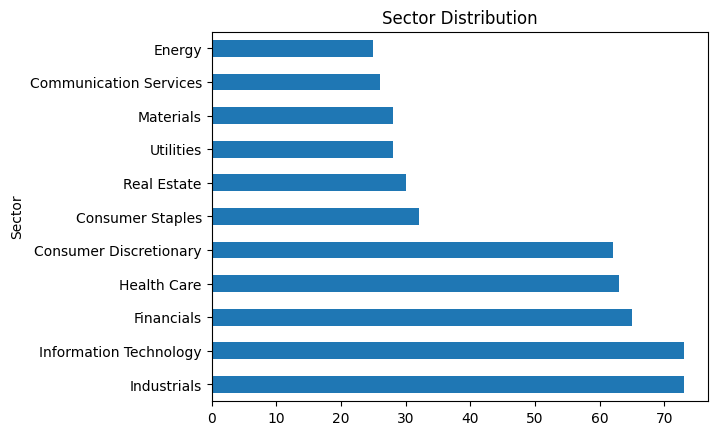

In [13]:
# Example: Top sectors by count
sp500_df['Sector'].value_counts().plot(kind='barh', title='Sector Distribution')

### 1.2 Reddit Data

We have data gotten from reddit. Files in `data/raw/...` contain files gotten from kaggle I focus on .... Here is a quick view as to how it looks like, (when looking at r/finance). Note in r/finance, there are no body posts were removed or deleted (just the titles remain!)

In [14]:
df_fin = pd.read_csv("data/raw/finance/submissions_reddit.csv")
df_inv = pd.read_csv("data/raw/investing/submissions_reddit.csv")
print("r/investing")
display(df_inv.head())
print("r/finance")
df_fin.head()


r/investing


,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko1c0d,canadawins12345,2021-01-01 00:18:40,2021-02-03 21:11:00,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.60,2,0,0,4,0,"Just out of curiosity, does anyone make moves ...",self,https://redd.it/ko1c0d
1,ko1kgt,jackp1208,2021-01-01 00:33:03,2021-02-03 21:11:00,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,1.00,1,0,0,1,0,[removed],default,https://redd.it/ko1kgt
2,ko1smu,cradle_of_humanity,2021-01-01 00:47:19,2021-02-03 21:11:00,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.50,0,0,0,1,0,I have been looking for an excel/google sheets...,self,https://redd.it/ko1smu
3,ko1u8z,rascally1980,2021-01-01 00:50:17,2021-02-03 21:11:00,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,1.00,1,0,0,1,0,[removed],default,https://redd.it/ko1u8z
4,ko1yjk,rascally1980,2021-01-01 00:57:44,2021-02-03 21:11:00,1970-01-01 00:00:00,0,0,0,0,0,...,NaN,0.64,6,0,0,14,0,One article mentions some bullish calls on the...,self,https://redd.it/ko1yjk


r/finance


,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,ko3ecd,bighlovd,2021-01-01 02:33:23,2021-02-04 06:28:30,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,0.50,0,0,0,0,0,NaN,default,https://redd.it/ko3ecd
1,ko4jed,naturalhighguy,2021-01-01 03:56:40,2021-02-04 06:28:30,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,0.38,0,0,0,11,0,NaN,default,https://redd.it/ko4jed
2,ko65fk,Venky2310,2021-01-01 05:55:12,2021-02-04 06:28:30,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,1.00,1,0,0,0,0,NaN,default,https://redd.it/ko65fk
3,koaw8g,[deleted],2021-01-01 12:57:48,2021-02-04 06:28:30,1970-01-01 00:00:00,0,0,0,1,1,...,NaN,1.00,1,0,0,0,0,[deleted],default,https://redd.it/koaw8g
4,kobbka,fintechinshorts,2021-01-01 13:31:53,2021-02-04 06:28:30,1970-01-01 00:00:00,0,0,0,1,0,...,NaN,1.00,1,0,0,0,0,NaN,default,https://redd.it/kobbka


Now to clean the data and keep what we may need. I'll make a new column that combines both the title and body of the post. If there is no body or it has been deleted, just title will be used. 

In [15]:
def pre_process_data(df):
    #drop unhelpful columns
    df = df[df.selftext != "[removed]"] #don't want removed...
    cols_to_drop = (list(df.columns[3:13]) + [df.columns[14]] + list(df.columns[16:19]) + [df.columns[20]] + list(df.columns[22:24]))
    df_new = df.drop(cols_to_drop, axis=1)
    
    # Combine title + selftext
    df_new["full_text"] = df_new["title"].fillna('') + " " + df_new["selftext"].fillna('')
    
     # Handle '[removed]' or '[deleted]' selftext entries
    is_removed = df_new["selftext"].isin(["[removed]", "[deleted]"])
    
    #fill in those rows with just the title
    df_new.loc[is_removed, "full_text"] = df_new["title"].fillna('')
    return df_new

df_f = pre_process_data(df_fin)
df_in = pre_process_data(df_inv)
df_in.tail()

,id,author,created,title,upvote_ratio,num_comments,selftext,full_text
41854,rstcx1,don_cornichon,2021-12-31 12:56:58,"Since Solar ETFs are probably a bad bet, what ...",0.68,12,"I recently got out of TAN at a 50% loss, after...","Since Solar ETFs are probably a bad bet, what ..."
41864,rsvpiw,jedo89,2021-12-31 15:01:14,"All In Podcast, anyone listen? Chamath and oth...",0.80,109,This podcast made me realize that as soon as a...,"All In Podcast, anyone listen? Chamath and oth..."
41865,rsw14v,jammerjoint,2021-12-31 15:17:05,"Tesla recalls 475,000 vehicles over safety issues",0.89,160,Noticed this hasn't been posted yet.\n\nhttps:...,"Tesla recalls 475,000 vehicles over safety iss..."
41876,rsymr4,JackBogdanoff,2021-12-31 17:18:48,Target Date Index Funds Bad?,0.70,27,Hello and happy New Year!\n\nI have a question...,Target Date Index Funds Bad? Hello and happy N...
41889,rt2bq5,peachezandsteam,2021-12-31 20:18:14,Why does the NASDAQ open with extreme volatility?,0.56,5,"It seems that at 9:30 AM, the NASDAQ (at least...",Why does the NASDAQ open with extreme volatili...


#### Finding relevant posts

To find which comments to use, I will first clean the company names with the `sp500_df` dataset. Then I will tag the posts that have either any company name or their stock tickers. 

Note: Estimated runtime for the cell below is almost 13 seconds. It survices to look at results and follow along

In [16]:
import re

def clean_name(name: str) -> str:
    """
    Cleans a company name by:
    - Lowercasing and stripping punctuation
    - Repeatedly removing corporate suffixes (incl. plural variants)
    - Handling key company name remaps
    """
    # Step 1: Lower + remove punctuation + normalize spacing
    raw = name.lower()
    raw = re.sub(r"[^\w\s]", " ", raw)
    raw = re.sub(r"\s+", " ", raw).strip()

    # Step 2: Manual remaps (AFTER lower + punctuation strip)
    special_cases = {
        "amazon com inc": "amazon",
        "alphabet inc class a": "google",
        "alphabet inc class c": "alphabet"#,
       # "citigroup inc": "citi"
    }
    if raw in special_cases:
        return special_cases[raw]

    # Step 3: Generic suffix stripping
    suffix_re = re.compile(
        r"""\b(inc|corp|corporation|company|ltd|plc|group|
        holding[s]?|co|financial|system[s]?|international|wholesale)s?\b""",
        flags=re.I | re.X
    )

    prev = None
    while prev != raw:
        prev = raw
        raw = suffix_re.sub("", raw)

    return re.sub(r"\s+", " ", raw).strip()



# Load spaCy model with just the tokenizer to keep it lightweight
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger"])

# PhraseMatcher allows us to efficiently match cleaned company names in text
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

# Create a set of all tickers to enable fast lookup when using regex
ticker_set = set(sp500_df.Ticker)

# Clean all company names for use in the matcher
company_names = sp500_df.Company.apply(clean_name)

# Turn cleaned names into spaCy Doc objects for matching
patterns = [nlp.make_doc(name) for name in company_names]

# Register these patterns under the label "COMPANIES"
matcher.add("COMPANIES", patterns)

# Regex pattern to match ALLCAPS stock tickers (1 to 5 characters)
ticker_re = re.compile(r"\b([A-Z]{1,5})\b")


def find_firms(text):
    """
    Identifies company mentions and stock tickers within a block of text using:
    - PhraseMatcher for full company names
    - Regex for ALLCAPS tickers

    Args:
        text (str): Raw text from a Reddit post or comment

    Returns:
        list[str]: Sorted list of unique matched company names and/or tickers
    """
    doc = nlp(text)  # tokenize text

    # PhraseMatcher identifies any known company name patterns
    name_matches = [doc[start:end].text for _, start, end in matcher(doc)]

    # Regex captures any ticker-like words in all caps
    tickers = [m.group(1) for m in ticker_re.finditer(text) if m.group(1) in ticker_set]
    return sorted(set(name_matches + tickers)) # Combine and deduplicate


#Test example on the finance data:
start = time.time()
df_f["named_entity"] = df_f.full_text.apply(find_firms)
end = time.time()
print("Runtime:", end - start)

#view none empty tagged rows
df_f[df_f["named_entity"].apply(lambda x: isinstance(x, list) and len(x) > 0)].head()

Runtime: 14.754931211471558


,id,author,created,title,upvote_ratio,num_comments,selftext,full_text,named_entity
12,kov1ho,[deleted],2021-01-02 10:00:43,Tesla market cap and revenue compared to 10 la...,1.0,0,[deleted],Tesla market cap and revenue compared to 10 la...,[Tesla]
16,kp081n,Crypto_guide,2021-01-02 16:19:59,Bitcoin Crosses Warren Buffett’s Berkshire Hat...,1.0,0,NaN,Bitcoin Crosses Warren Buffett’s Berkshire Hat...,[Berkshire Hathaway]
20,kpg5f2,acawebb10,2021-01-03 07:19:04,Why Is Health Insurance A Must For Every Indiv...,1.0,0,NaN,Why Is Health Insurance A Must For Every Indiv...,[A]
24,kpjqwu,ForexGuru20,2021-01-03 12:22:41,Epic trading - the new MLM Forex Network,1.0,0,NaN,Epic trading - the new MLM Forex Network,[MLM]
29,kppwci,fintechinshorts,2021-01-03 18:31:42,GenoPalate: Closes $4M Series A Financing Roun...,1.0,0,NaN,GenoPalate: Closes $4M Series A Financing Roun...,[A]


Yikes! Looks like the stock "A" was falsely tagged anytime someone used a capital A. This is will fixed later. I will not drop all the rows containing A for now since they might include other stock or company names.

#### Segmenting Company Text

Now for the challenging part. A company text is starts the moment a company/stock name is mentioned. It stops only when another stock or company name is mentioned. socks that appear together will get the same sentence(s) for example:

"I am holding tesla and apple for now. NVDA is about to skyrocket!"

becomes

|company_stock | company_text| full_text
|---------|-------------------|-----------------
|Tesla, Inc, TSLA | I am holding tesla and apple for now.| I am holding tesla and apple for now. NVDA is about to skyrocket!|
|Apple Inc., AAPL| I am holding tesla and apple for now.| I am holding tesla and apple for now. NVDA is about to skyrocket!|
|Nvidia, NVDA| NVDA is about to skyrocket!| I am holding tesla and apple for now. NVDA is about to skyrocket!|

In [17]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger"])
nlp.add_pipe("sentencizer")

caps_word_re = re.compile(r"\b[A-Z]{1,5}\b")
ignored_caps_words = {"PE", "DCA", "DRIP", "ETF", "GDP", "ROTH", "IRA", "HSA", "WSB"}

clean_to_ticker = {clean_name(name): ticker for ticker, name in zip(sp500_df.Ticker, sp500_df.Company)}
ticker_to_name = dict(zip(sp500_df.Ticker, sp500_df.Company))
company_name_set = set(clean_to_ticker.keys())


def build_rows_from_named_entity(row):
    full_text = row["full_text"]
    named_entities = row["named_entity"]
    created = row["created"]
    upvote_ratio = row["upvote_ratio"]
    num_comments = row["num_comments"]

    doc = nlp(full_text)
    sentences = [sent.text.strip() for sent in doc.sents]

    entity_map = defaultdict(list) #dictionary with value list...
    for ent in named_entities:
        if ent in ticker_to_name:
        # It's already a ticker!
            ticker = ent
        else:
        # Try mapping cleaned company name to a ticker
            cleaned = clean_name(ent)
            ticker = clean_to_ticker.get(cleaned)

        if ticker:
            entity_map[ticker].append(ent)



    all_rows = []
    for ticker, mentions in entity_map.items():
        company_name = ticker_to_name.get(ticker)
        if not company_name:
            continue
        target_clean_name = clean_name(company_name)
        sentence_indices = []

        for i, sent in enumerate(sentences):
            sent_lower = sent.lower()
            sent_caps = set(caps_word_re.findall(sent)) - ignored_caps_words
            if ticker in sent_caps or target_clean_name in sent_lower:
                sentence_indices.append(i)

        if not sentence_indices:
            continue

        start_idx = sentence_indices[0]
        other_tickers = set(entity_map.keys()) - {ticker}
        other_names = {clean_name(ticker_to_name[t]) for t in other_tickers}
        end_idx = len(sentences)

        for j in range(start_idx + 1, len(sentences)):
            sent = sentences[j]
            sent_lower = sent.lower()
            caps_in_sent = set(caps_word_re.findall(sent)) - ignored_caps_words
            if any(tok in other_tickers for tok in caps_in_sent) or any(name in sent_lower for name in other_names):
                end_idx = j
                break

        company_text = " ".join(sentences[start_idx:end_idx]).strip()
        company_stock = f"{company_name}, {ticker}"

        all_rows.append({
            "company_stock": company_stock,
            "company_text": company_text,
            "full_text": full_text,
            "created": created,
            "upvote_ratio": upvote_ratio,
            "num_comments": num_comments,
            "named_entity": named_entities
        })

    return all_rows

def final_df(df):
    data = df.copy()
    all_rows = []
    for _, row in data.iterrows():
        all_rows.extend(build_rows_from_named_entity(row))
    return pd.DataFrame(all_rows)

#### All together

Note: Do not run this code!! It will take more than an hour. The datasets are saved in `data/final/`, and we will refer to them later.

In [ ]:
subreddits = {"investing", "stocks", "stockmarket", "wallstreetbets", "finance", "options"}
df = {}

for sub in subreddits:
    print(f"\n Processing r/{sub}...")
    start_time = time.time()
    df_raw = pre_process_data(pd.read_csv(f"data/raw/{sub}/submissions_reddit.csv"))
    df_raw["named_entity"] = df_raw.full_text.apply(find_firms)
    df_raw = df_raw[df_raw["named_entity"].apply(lambda x: len(x) > 0)]
    df[sub] = final_df(df_raw)
    
    df[sub].to_csv(f"data/final/{sub}_firm_words.csv", index=False)
    end_time = time.time()
    print(f" Finished r/{sub} in {end_time - start_time:.2f} seconds")

Let's see how one of them looks like after cleaning!

In [18]:
data_invest = pd.read_csv(f"data/final/investing_firm_words.csv")
data_invest.head()

,company_stock,company_text,full_text,created,upvote_ratio,num_comments,named_entity
0,"Western Digital, WDC",Western Digital (WDC) rose 11.83% today. Anybo...,Western Digital (WDC) rose 11.83% today. Anybo...,2021-01-01 00:57:44,0.64,14,"['WDC', 'Western Digital']"
1,"American Airlines Group, AAL",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43,0.42,3,"['AAL', 'AMZN', 'DLTR', 'TSLA', 'WMT']"
2,"Amazon.com Inc., AMZN",My next largest sector is consumer discretiona...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43,0.42,3,"['AAL', 'AMZN', 'DLTR', 'TSLA', 'WMT']"
3,"Dollar Tree, DLTR",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43,0.42,3,"['AAL', 'AMZN', 'DLTR', 'TSLA', 'WMT']"
4,"Tesla, Inc., TSLA",There are so many astounding run-ups I knew ab...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43,0.42,3,"['AAL', 'AMZN', 'DLTR', 'TSLA', 'WMT']"


Nice! The company text looks so much better. We ran into some problems though! There are some stock name that are all too common english or finance words and may be counted under that company! Words like "key", "ball," "all," "target," (which could be referring to target funds and not the company), "dd" (due diligence), "nasdaq," "dow" (which may be referring to the exchanges and NOT the company!"). Nasdaq's stock is $NDAQ, so I will drop rows that tagged nasdaq and not their stock (similar with "target" and "TGT."

Other changes include: Making the date columns more readable,etc

In [19]:
import ast
import warnings
warnings.filterwarnings("ignore")

def clean_entity(row):
    if isinstance(row, str):
        row = ast.literal_eval(row) # make it an actual list
        return ', '.join(row)
    if isinstance(row, list):
        return ', '.join(row)
    

#problematic companies!
def drop_rows(df):
    # Define drop pairs (company_stock, entity_substring)
    drop_pairs = [
        ("Ball Corp, BLL", "ball"),
        ("Dow Inc., DOW", "dow"),
        ("Nasdaq, Inc., NDAQ", "nasdaq"),
        ("KeyCorp, KEY", "key"),
        ("Target Corp., TGT" , "target"),
        ("Allstate Corp, ALL", "all"),
        ("DuPont de Nemours Inc, DD", "dd"),
        ("Agilent Technologies Inc, A", "a"),
        #("Citigroup Inc., C", "c"),
        ("American International Group, AIG", "american"),
        ("Citizens Financial Group, CFG", "citizens"),
        ("Principal Financial Group, PFG", "principal"),
        ("Alexandria Real Estate Equities, ARE", "are")
    ]
    
    # Filter rows if both key and values hold!
    mask = ~df.apply(
        lambda row: any(
            (row["company_stock"] == company) and (entity in row["named_entity"].lower())
            for company, entity in drop_pairs
        ),
        axis=1
    )
    clean_df = df[mask].drop_duplicates() #filter and remove duplicates
    return clean_df 

#get the ticker from the company names
def extract_company_ticker(company_stock_str):
    parts = [part.strip() for part in company_stock_str.split(',')]
    if len(parts) >= 2:
        ticker = parts[-1]  # The last part is likely the ticker
        company_parts = parts[:-1]  # All parts before the last form the company name
        company = ', '.join(company_parts) # Join them back with a comma
        return company, ticker
    else:
        return parts[0], parts[1] # Or handle cases with fewer than two parts as needed

    #apply(pd.Series)

#format date
def get_date(df):
    # Convert created to datetime (UTC-safe)
    df["created"] = pd.to_datetime(df["created"], utc=True)

    # Individual date components
    df["month"] = df["created"].dt.month# Numeric month (1–12)
    df["day"] = df["created"].dt.day # Day of month (1–31)
    df["month_day"] = df["created"].dt.strftime("%b %d")  # e.g. 'Jan 01'

    # Time of day label
    def label_time(hour):
        if 0 <= hour < 12:
            return "morning"
        elif 12 <= hour < 17:
            return "afternoon"
        else:
            return "evening"

    df["time_of_day"] = df["created"].dt.hour.apply(label_time)

    return df
    
#all together post cleaning
def post_cleaning(df):
    #clean entity name
    df["named_entity"] = df["named_entity"].apply(clean_entity)
    df[['company', 'ticker']] = df['company_stock'].apply(extract_company_ticker).apply(pd.Series)
    df = drop_rows(df)
    df = get_date(df)
    return df


So each dataset now looks like this:

In [20]:
post_cleaning(data_invest.head())

,company_stock,company_text,full_text,created,upvote_ratio,num_comments,named_entity,company,ticker,month,day,month_day,time_of_day
0,"Western Digital, WDC",Western Digital (WDC) rose 11.83% today. Anybo...,Western Digital (WDC) rose 11.83% today. Anybo...,2021-01-01 00:57:44+00:00,0.64,14,"WDC, Western Digital",Western Digital,WDC,1,1,Jan 01,morning
1,"American Airlines Group, AAL",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",American Airlines Group,AAL,1,1,Jan 01,morning
2,"Amazon.com Inc., AMZN",My next largest sector is consumer discretiona...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",Amazon.com Inc.,AMZN,1,1,Jan 01,morning
3,"Dollar Tree, DLTR",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",Dollar Tree,DLTR,1,1,Jan 01,morning
4,"Tesla, Inc., TSLA",There are so many astounding run-ups I knew ab...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT","Tesla, Inc.",TSLA,1,1,Jan 01,morning


### Structuring

We are finally done cleaning and getting our general dataset, we can clean and combine them all

In [21]:
import pandas as pd
import re
import spacy
from collections import defaultdict

# Load your processed data 
all_firm_dfs = {}
subreddits = {"investing","stocks","stockmarket","wallstreetbets","finance","options"}
for sub in subreddits:
    #load AND clean each post
    all_firm_dfs[sub] = post_cleaning(pd.read_csv(f"data/final/{sub}_firm_words.csv"))

# Combine data from all subreddits into a single DataFrame
combined_df = pd.concat(all_firm_dfs.values(), ignore_index=True)
combined_df.head()

,company_stock,company_text,full_text,created,upvote_ratio,num_comments,named_entity,company,ticker,month,day,month_day,time_of_day
0,"Western Digital, WDC",Western Digital (WDC) rose 11.83% today. Anybo...,Western Digital (WDC) rose 11.83% today. Anybo...,2021-01-01 00:57:44+00:00,0.64,14,"WDC, Western Digital",Western Digital,WDC,1,1,Jan 01,morning
1,"American Airlines Group, AAL",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",American Airlines Group,AAL,1,1,Jan 01,morning
2,"Amazon.com Inc., AMZN",My next largest sector is consumer discretiona...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",Amazon.com Inc.,AMZN,1,1,Jan 01,morning
3,"Dollar Tree, DLTR",My biggest gains have been from well-timed pur...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT",Dollar Tree,DLTR,1,1,Jan 01,morning
4,"Tesla, Inc., TSLA",There are so many astounding run-ups I knew ab...,Let's reflect on our performance in 2020 *Happ...,2021-01-01 03:20:43+00:00,0.42,3,"AAL, AMZN, DLTR, TSLA, WMT","Tesla, Inc.",TSLA,1,1,Jan 01,morning


For fun, let's see how many companies in the S&P 500 but not in our dataset

In [22]:

print(f"Number of unique companies in our dataset: {len(combined_df['company_stock'].unique())}")
print(f"Number of unique companies in the S&P500 in 2021: {len(sp500_df.Company.unique())}")


Number of unique companies in our dataset: 499
Number of unique companies in the S&P500 in 2021: 505


This makes sense, as we dropped some companies that may cause potential problems!! Just to make sure, let's identify the companies that are no in our dataset:


In [23]:
# Now, proceed with identifying companies not in our datser
not_in_df =  sp500_df[~sp500_df['Ticker'].isin(combined_df['ticker'].unique())]
not_in_df_company = not_in_df['Ticker'].unique()
print("\nCompany names that are not in dataset but are in the S&P 500:\n")
#print(not_in_df_company)

not_in_df


Company names that are not in dataset but are in the S&P 500:


,Ticker,Company,Sector,Industry
11,A,Agilent Technologies Inc,Health Care,Health Care Equipment
21,ALL,Allstate Corp,Financials,Property & Casualty Insurance
108,C,Citigroup Inc.,Financials,Diversified Banks
153,DOW,Dow Inc.,Materials,Commodity Chemicals
269,KEY,KeyCorp,Financials,Regional Banks
477,WRB,W. R. Berkley Corporation,Financials,Property & Casualty Insurance


This implies that Target, BallCorp, and NASDAQ are still in the dataset. Citigroup is here because no one mentioned Citigroup... It's possible "Citi" was mentioned but for now, this was dropped in this analysis.

**Back to manipulation**

For our first analysis, we want to generate embeddings for firms, no time component required. For this, we would want to join ALL the texts for each firm.


In [24]:
company_text_dict = defaultdict(list)
for _, row in combined_df.iterrows():
    company = row['company_stock']
    text = row['company_text']
    company_text_dict[company].append(text)

# Join all text segments for each company
aggregated_company_text = {
    company: " ".join(texts) for company, texts in company_text_dict.items()
}

aggregated_df = pd.DataFrame(list(aggregated_company_text.items()), columns=['company', 'aggregated_text'])
aggregated_df.head()

,company,aggregated_text
0,"Western Digital, WDC",Western Digital (WDC) rose 11.83% today. Anybo...
1,"American Airlines Group, AAL",My biggest gains have been from well-timed pur...
2,"Amazon.com Inc., AMZN",My next largest sector is consumer discretiona...
3,"Dollar Tree, DLTR",My biggest gains have been from well-timed pur...
4,"Tesla, Inc., TSLA",There are so many astounding run-ups I knew ab...


We would also like to tidy up the text to remove links, usernames, stop words, and other unimformative messages. Since it's social meddia, the special character "!" and emoji's will not be removed from the text, as I feel that has a more important in measuring sentiment with the text.

In [25]:
#!pip install emoji #run this

In [26]:
import emoji
#more text cleaning!

#to clean the text!
def further_clean_text(text):
    """
    Performs additional cleaning on the aggregated text, keeping exclamation marks.
    - Removes URLs
    - Removes mentions of users (e.g., u/username)
    - Removes subreddit mentions (e.g., r/subreddit)
    - Removes special characters (except ! and emoji's) and extra whitespace
    """
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'u/\S+', '', text)
    text = re.sub(r'r/\S+', '', text)
    
    # Keep alphanumeric, whitespace, !, and emojis
    cleaned_chars = ''.join(c if c.isalnum() or c.isspace() or c == '!' or emoji.is_emoji(c) else '' for c in text)
    text = re.sub(r'\s+', ' ', cleaned_chars).strip()
    return text

aggregated_df['cleaned_text'] = aggregated_df['aggregated_text'].apply(further_clean_text)
aggregated_df.tail()


,company,aggregated_text,cleaned_text
494,"Ameren Corp, AEE",Utilities** | Ameren Corp | **AEE** | 0.67% \...,Utilities Ameren Corp AEE 067 7 ETF Ticker inv...
495,"Packaging Corporation of America, PKG",CSE: PKG\n\nParcelPal Technology Inc provides ...,CSE PKG ParcelPal Technology Inc provides all ...
496,"WestRock, WRK",Materials** | Westrock Co | **WRK** | 2.12% \...,Materials Westrock Co WRK 212 9 Materials West...
497,"Arthur J. Gallagher & Co., AJG",Financials** | Arthur J Gallagher & Co | **AJG...,Financials Arthur J Gallagher Co AJG 184 8 Ene...
498,"Alexandria Real Estate Equities, ARE",ETFs with Investments in SP500 Winners of 9/20...,ETFs with Investments in SP500 Winners of 9202...


#### Creating Embeddings

I use the `RepresentLM-v1` hugging face model. This is fine-tuned on final news data, which was pretrained on the `Stories-LM`model that is trained on headlines.

First, insure `sentence-transformers` is installed: If you haven't already, install it using pip:


In [27]:
#!pip install -U sentence-transformers


**Load the RepresentLM model:**

In [28]:
#import transformers
from sentence_transformers import SentenceTransformer

start = time.time()
model = SentenceTransformer('RepresentLM/RepresentLM-v1')
end = time.time()

print("duration:", end - start)

duration: 1.4153761863708496


Now directly using the model.encode() method on the `cleaned_text` column of the aggregated_df.

In [29]:
start = time.time()
company_embeddings = model.encode(aggregated_df['cleaned_text'].tolist())

# Add the embeddings to your DataFrame
aggregated_df['embeddings'] = list(company_embeddings)
end = time.time()

print("duration:", end - start)
display(aggregated_df[['company', 'cleaned_text', 'embeddings']].head())
print(f"Shape of embeddings: {aggregated_df['embeddings'][0].shape}")

duration: 26.814204216003418


,company,cleaned_text,embeddings
0,"Western Digital, WDC",Western Digital WDC rose 1183 today Anybody kn...,"[-0.59001064, -0.48082572, 0.09033184, -1.5291..."
1,"American Airlines Group, AAL",My biggest gains have been from welltimed purc...,"[-0.024294699, -0.24288073, 0.75604314, -0.580..."
2,"Amazon.com Inc., AMZN",My next largest sector is consumer discretiona...,"[-0.30824435, 0.03959648, 1.3430741, -0.735483..."
3,"Dollar Tree, DLTR",My biggest gains have been from welltimed purc...,"[0.076447286, -0.101731464, 0.66945153, -0.517..."
4,"Tesla, Inc., TSLA",There are so many astounding runups I knew abo...,"[-0.2733019, 0.1076045, 0.79615235, -0.7278644..."


Shape of embeddings: (768,)


The `model.encode()` method in sentence-transformers handles the tokenization and embedding generation (RepresentLM specifically makes each sentence/post/firm text a 768 by 1 embedding, and it returns a single vector embedding for each input text).

### What to do with the company_embeddings:

Now that we have these embeddings, we can proceed with various downstream tasks.

**Company Similarity Analysis:** Calculate the cosine similarity between the embedding vectors of different companies. Companies with higher cosine similarity are likely discussed in more similar contexts on Reddit

In [30]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

random.seed(48104)
def calculate_similarity(embeddings):
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

similarity_matrix = calculate_similarity(np.array(aggregated_df['embeddings'].tolist()))

# You can then analyze this matrix to find similar companies
# For example, to find the most similar companies to the first company:
first_company = aggregated_df['company'].iloc[0]
similarities = similarity_matrix[0]
sorted_indices = np.argsort(similarities)[::-1][1:] # Sort by similarity (descending) excluding self
top_n = 10

print(f"Top {top_n} most similar companies to {first_company}:")
for i in sorted_indices[:top_n]:
    print(f"- {aggregated_df['company'].iloc[i]} (Similarity: {similarities[i]:.4f})")

Top 10 most similar companies to Western Digital, WDC:
- IHS Markit Ltd., INFO (Similarity: 0.8118)
- Xilinx, XLNX (Similarity: 0.8117)
- Catalent, CTLT (Similarity: 0.8098)
- Akamai Technologies Inc, AKAM (Similarity: 0.8056)
- Sherwin-Williams, SHW (Similarity: 0.8054)
- Tapestry, Inc., TPR (Similarity: 0.8048)
- M&T Bank Corp., MTB (Similarity: 0.8044)
- Host Hotels & Resorts, HST (Similarity: 0.8025)
- PerkinElmer, PKI (Similarity: 0.7999)
- Gap Inc., GPS (Similarity: 0.7985)


So many pharmaceutical companies seem to be similar to tesla as 2021. One explanation is that in 2021, we were fresh off the pandemic, and  pharmaceutical stocks saw a lot of growth as well as tesla. Besides these shocks, the most accurate seems to be American Airlines

**PSNE and tSNE**

Visualizing the high-dimensional embeddings of our companies can provide valuable insights into how the language model understands their relationships based on Reddit discussions. If the embeddings capture meaningful semantic similarities, we might expect companies within the same economic sector to cluster together in a lower-dimensional space.

Visualizing all ~400 companies directly can lead to cluttered and less interpretable plots. To gain a clearer initial understanding, we'll first visualize 5 randomly selected firms from each sector as defined in the S&P 500 data.

We'll employ two popular dimensionality reduction techniques for visualization: Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE).

PCA aims to preserve the global variance in the data, while t-SNE focuses on preserving the local neighborhood structure, often revealing clusters more effectively.


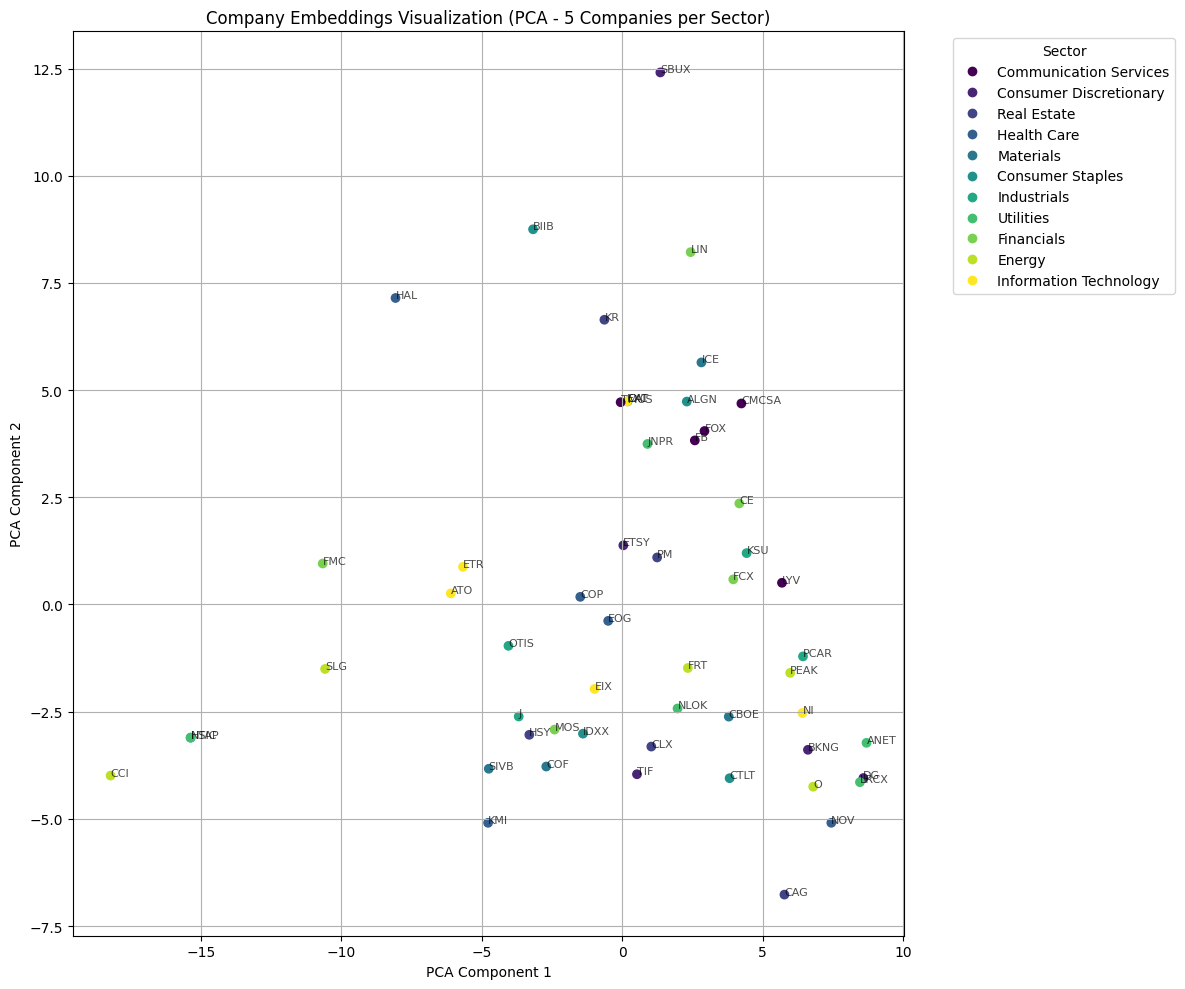

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


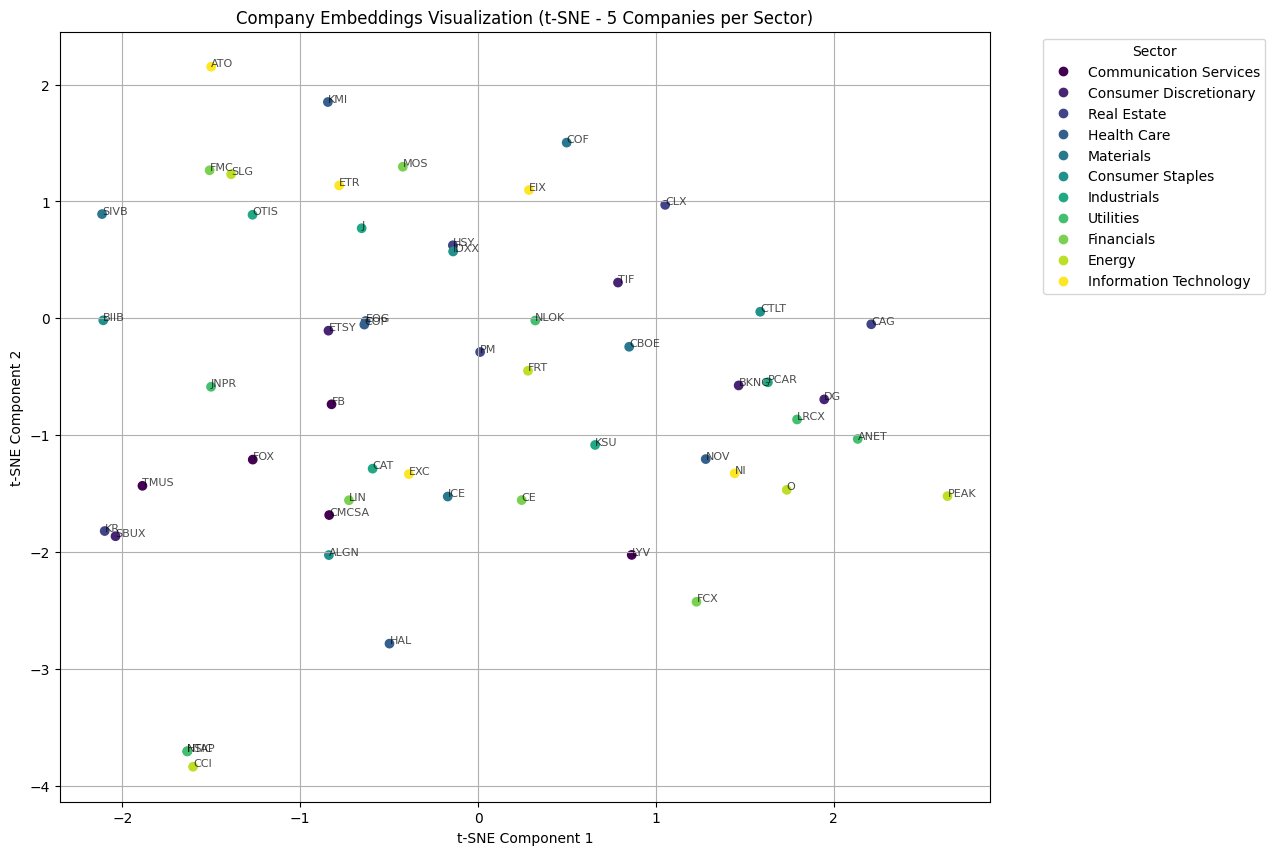

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

#get the ticker using our function from before!
aggregated_df[['Company', 'ticker']] = aggregated_df['company'].apply(extract_company_ticker).apply(pd.Series)

# Load the S&P 500 constituents data
sp500_df = pd.read_csv("data/sp500_2021_constituents.csv")

fortune_500_tickers = ticker_to_name
# Create a DataFrame from the Fortune 500 tickers and names
fortune_df = pd.DataFrame(list(fortune_500_tickers.items()), columns=['Ticker', 'Company'])

# Merge with the S&P 500 data to get the sector
merged_df = pd.merge(fortune_df, sp500_df[['Symbol', 'GICS Sector']], left_on='Ticker', right_on='Symbol', how='inner')
merged_df = merged_df.rename(columns={'GICS Sector': 'Sector'}).drop(columns=['Symbol'])

# Group by sector and select 5 random companies from each
selected_companies_df = merged_df.groupby('Sector').apply(lambda x: x.sample(n=min(5, len(x)), random_state=48104)).reset_index(drop=True)

# Filter the aggregated_df to include only these selected companies
selected_tickers = selected_companies_df['Ticker'].tolist()
selected_aggregated_df = aggregated_df[aggregated_df['Company'].isin(selected_companies_df['Company'])].copy()

# Merge with selected_companies_df to get tickers and sectors for plotting
selected_aggregated_df = pd.merge(selected_aggregated_df, selected_companies_df[['Company', 'Ticker', 'Sector']], left_on='Company', right_on='Company', how='inner').drop(columns=['Company'])

# Convert embeddings to a NumPy array
embeddings_subset = np.array(selected_aggregated_df['embeddings'].tolist())

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings_subset)
selected_aggregated_df['pca_1'] = reduced_embeddings_pca[:, 0]
selected_aggregated_df['pca_2'] = reduced_embeddings_pca[:, 1]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(selected_aggregated_df['pca_1'], selected_aggregated_df['pca_2'], c=selected_aggregated_df['Sector'].astype('category').cat.codes, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Company Embeddings Visualization (PCA - 5 Companies per Sector)')
plt.grid(True)

# Add annotations for tickers
for i, row in selected_aggregated_df.iterrows():
    plt.annotate(row['Ticker'], (row['pca_1'], row['pca_2']), fontsize=8, alpha=0.7)

# Create a legend for the sectors
handles, labels = scatter.legend_elements()
plt.legend(handles, selected_aggregated_df['Sector'].unique(), title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30.0, embeddings_subset.shape[0] - 1), n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(embeddings_subset)
selected_aggregated_df['tsne_1'] = reduced_embeddings_tsne[:, 0]
selected_aggregated_df['tsne_2'] = reduced_embeddings_tsne[:, 1]

plt.figure(figsize=(12, 10))
scatter_tsne = plt.scatter(selected_aggregated_df['tsne_1'], selected_aggregated_df['tsne_2'], c=selected_aggregated_df['Sector'].astype('category').cat.codes, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Company Embeddings Visualization (t-SNE - 5 Companies per Sector)')
plt.grid(True)

# Add annotations for tickers
for i, row in selected_aggregated_df.iterrows():
    plt.annotate(row['Ticker'], (row['tsne_1'], row['tsne_2']), fontsize=8, alpha=0.7)

# Create a legend for the sectors
handles_tsne, labels_tsne = scatter_tsne.legend_elements()
plt.legend(handles_tsne, selected_aggregated_df['Sector'].unique(), title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.tight_layout()
plt.show()

While some companies in the same sector are beside each other, it doesnt seem to be a pattern and it looks like mostly noice. Since it's social media data, it makes sense that the more popular ones are being talked about, as ooposed to relatively less popular ones.

Thus, better approach would be to use the top 5 most popular companies in  more general sectors.

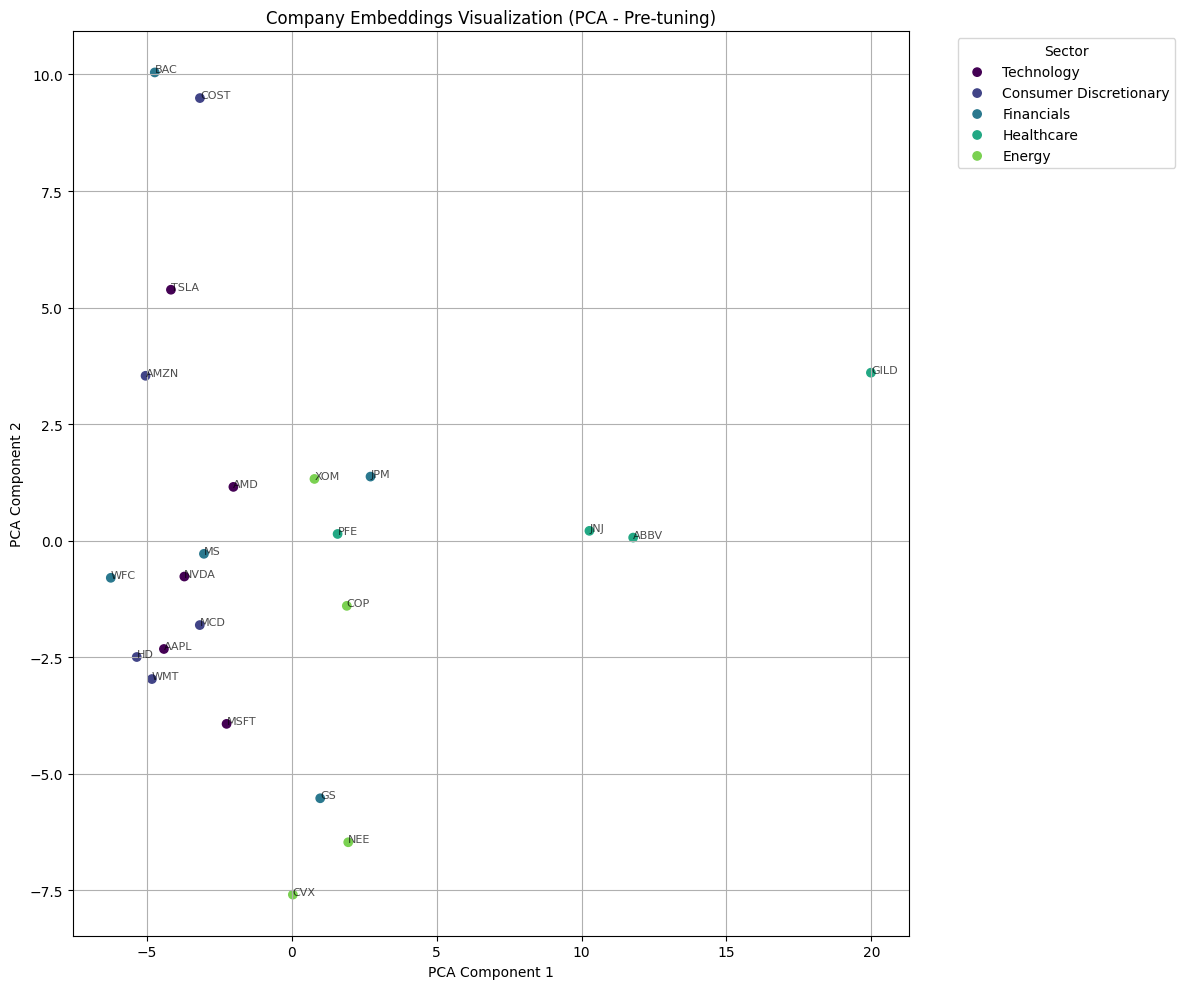

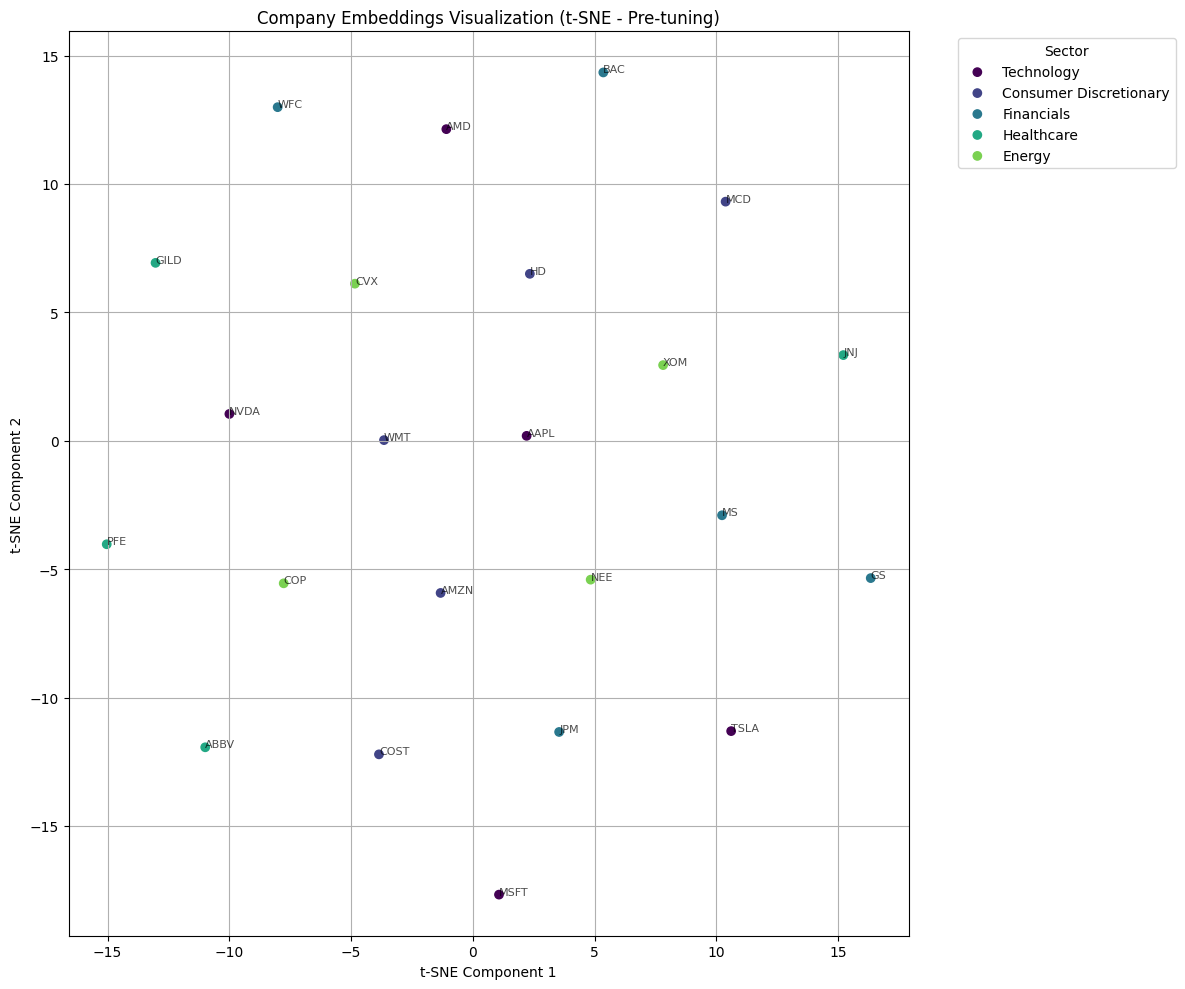

In [32]:
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Create the output directory if it doesn't exist
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

#  explicit lists of likely popular companies per sector (using tickers)
popular_companies_by_sector = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMD'],
    'Consumer Discretionary': ['AMZN', 'COST', 'WMT', 'MCD', 'HD'],
    'Financials': ['JPM', 'BAC', 'MS', 'WFC', 'GS'],
    'Healthcare': ['PFE', 'MRNA', 'JNJ', 'ABBV', 'GILD'],
    'Energy': ['XOM', 'CVX', 'NEE', 'COP', 'BP']
}

# Create a list of the top popular tickers
top_popular_tickers = []
for sector, tickers in popular_companies_by_sector.items():
    top_popular_tickers.extend(tickers)

# Filter the aggregated_df to include only these top popular tickers
selected_aggregated_df = aggregated_df[aggregated_df['ticker'].isin(top_popular_tickers)].copy()

# Create a mapping from ticker to sector
ticker_to_sector = {}
for sector, tickers in popular_companies_by_sector.items():
    for ticker in tickers:
        ticker_to_sector[ticker] = sector

# Add a 'Sector' column to selected_aggregated_df based on the mapping
selected_aggregated_df['Sector'] = selected_aggregated_df['ticker'].map(ticker_to_sector)

# Get unique sectors and create a mapping for colors
unique_sectors = list(popular_companies_by_sector.keys())
sector_to_color = {sector: plt.cm.viridis(i/len(unique_sectors)) for i, sector in enumerate(unique_sectors)}
selected_aggregated_df['color'] = selected_aggregated_df['Sector'].map(sector_to_color)

# Convert embeddings to a NumPy array
embeddings_subset = np.array(selected_aggregated_df['embeddings'].tolist())

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings_subset)
selected_aggregated_df['pca_1'] = reduced_embeddings_pca[:, 0]
selected_aggregated_df['pca_2'] = reduced_embeddings_pca[:, 1]

plt.figure(figsize=(12, 10))
for sector in popular_companies_by_sector.keys():  # Iterate through dictionary keys
    subset_df = selected_aggregated_df[selected_aggregated_df['Sector'] == sector]
    plt.scatter(subset_df['pca_1'], subset_df['pca_2'], c=subset_df['color'], label=sector)
    # Add ticker annotations
    for i, row in subset_df.iterrows():
        plt.annotate(row['ticker'], (row['pca_1'], row['pca_2']), fontsize=8, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Company Embeddings Visualization (PCA - Pre-tuning)')
plt.grid(True)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_pre_tuning.png"))  # Save the PCA plot
plt.show()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30.0, embeddings_subset.shape[0] - 1), n_iter=300)
reduced_embeddings_tsne = tsne.fit_transform(embeddings_subset)
selected_aggregated_df['tsne_1'] = reduced_embeddings_tsne[:, 0]
selected_aggregated_df['tsne_2'] = reduced_embeddings_tsne[:, 1]

plt.figure(figsize=(12, 10))
for sector in popular_companies_by_sector.keys():  # Iterate through dictionary keys
    subset_df = selected_aggregated_df[selected_aggregated_df['Sector'] == sector]
    plt.scatter(subset_df['tsne_1'], subset_df['tsne_2'], c=subset_df['color'], label=sector)
    # Add ticker annotations
    for i, row in subset_df.iterrows():
        plt.annotate(row['ticker'], (row['tsne_1'], row['tsne_2']), fontsize=8, alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Company Embeddings Visualization (t-SNE - Pre-tuning)')
plt.grid(True)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "TSNE_pre_tuning.png"))  # Save the t-SNE plot
plt.show()

tSNE does not really show us any grouping but PCA does. Some sectora are close but it seems noisy. Can we make our embeddings better maybe?




### Objective

----
We want to fine-tune a pretrained sentence encoder (RepresentLM) so that messages from the same firm are embedded closer together than messages from different firms. This will improve clustering!

We will:

- Use pairwise contrastive loss

- Train using SGD (not Adam)




Load Tokenizer + Base Model

In [33]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load pretrained RepresentLM model and tokenizer from HuggingFace
model_name = "RepresentLM/RepresentLM-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

This gives us a transformer that has already learned how to embed sentences in a meaningful way. We’ll fine-tune it on our specific task (firm identity) to make it even more domain-specific.

Building a Sentence Embedding Model

In [34]:
import torch.nn as nn

# Extract [CLS] token as a fixed-size representation of the sentence
class RepresentEncoder(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = base_model  # RepresentLM

    def forward(self, input_ids, attention_mask):
        """
        input_ids: tensor of shape (batch_size, sequence_length)
            - These are the tokenized input texts. Each number corresponds to a word/piece.
        attention_mask: tensor of shape (batch_size, sequence_length)
            - Tells the model which tokens are actual input (1) and which are padding (0)

        Returns:
        --------
        sentence_embedding: tensor of shape (batch_size, hidden_dim)
            - A single vector representing each full input sentence, taken from the [CLS] token
        """

        # Get all hidden states from the transformer
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Use the embedding of the [CLS] token (first token), which is designed to summarize the sentence
        cls_embedding = outputs.last_hidden_state[:, 0]

        return cls_embedding


The `[CLS]` token in transformers is designed to represent the entire sentence. We’ll use it as the vector for contrastive comparison.

### Create Text Pairs

In [35]:
from torch.utils.data import Dataset

class ContrastiveTextDataset(Dataset):
    def __init__(self, examples, tokenizer, max_length=128):
        """
        Initializes the dataset for contrastive learning.

        Parameters:
        -----------
        examples : list of (str, str, float)
            Each item is a (text1, text2, label) tuple.
            - text1, text2: two texts to compare
            - label: 1.0 if same firm (positive pair), 0.0 if different firms (negative pair)
        
        tokenizer : HuggingFace tokenizer
            Used to tokenize both texts in each pair.
        
        max_length : int
            Maximum sequence length (used for padding/truncation).
        """
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        """
        Returns a tokenized example at the given index.

        Output:
        -------
        A dict containing:
        - input1_ids, input1_mask: token IDs and attention mask for text1
        - input2_ids, input2_mask: token IDs and attention mask for text2
        - label: float (1.0 or 0.0) indicating if the pair is from the same firm
        """

        # Get text1, text2, and label for the current pair
        text1, text2, label = self.examples[idx]

        # Tokenize both texts independently
        tok1 = self.tokenizer(text1, padding='max_length', truncation=True,
                              max_length=self.max_length, return_tensors='pt')
        tok2 = self.tokenizer(text2, padding='max_length', truncation=True,
                              max_length=self.max_length, return_tensors='pt')

        # Return input IDs and attention masks for both texts, and the label
        return {
            'input1_ids': tok1['input_ids'].squeeze(0),       # Shape: [seq_len]
            'input1_mask': tok1['attention_mask'].squeeze(0), # 1 = real token, 0 = padding
            'input2_ids': tok2['input_ids'].squeeze(0),
            'input2_mask': tok2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)   # float32 for contrastive loss
        }

    def __len__(self):
        """
        Total number of contrastive examples.
        """
        return len(self.examples)


Quick Explanation:

- Independent tokenization: Contrastive loss needs two separate embeddings, so we process each input separately.

- Attention masks: These tell the transformer which tokens are real and which are padding, which is critical to prevent the model from learning from padding


#### Contrastive Loss Function

We’ll use the pairwise contrastive loss introduced in Hadsell et al. (2006). It encourages the model to:

- Pull similar pairs (e.g., same firm messages) closer together

- Push dissimilar pairs at least `margin` apart

The **contrastive loss** for a pair of embeddings $\mathbf{e}_1, \mathbf{e}_2$ and label $y \in \{0, 1\}$ is defined as:

$\mathcal{L} = y \cdot \| \mathbf{e}_1 - \mathbf{e}_2 \|^2 + (1 - y) \cdot \left( \max(0, m - \| \mathbf{e}_1 - \mathbf{e}_2 \|) \right)^2$

Where:
 
- $y = 1$ if the pair is similar (i.e., from the same firm), and $y = 0$ if the pair is dissimilar (i.e., from different firms).
-  $\| \mathbf{e}_1 - \mathbf{e}_2 \|$ is the Euclidean distance between the two sentence embeddings.
- $m$ is the margin — a threshold that determines how far apart dissimilar pairs should be.


In [36]:
import torch.nn.functional as F

def contrastive_loss(emb1, emb2, labels, margin=1.0):
    """
    Compute contrastive loss between pairs of embeddings.

    Parameters:
    -----------
    emb1 : torch.Tensor of shape (batch_size, hidden_dim)
        Embeddings for the first text in the pair
    emb2 : torch.Tensor of shape (batch_size, hidden_dim)
        Embeddings for the second text in the pair
    labels : torch.Tensor of shape (batch_size,)
        Labels: 1.0 for positive pairs (same firm), 0.0 for negative pairs (different firm)
    margin : float
        The minimum distance that dissimilar pairs should be apart

    Returns:
    --------
    loss : torch.Tensor (scalar)
        Averaged contrastive loss for the batch
    """

    # Step 1: Compute Euclidean distance between each pair of embeddings
    distance = F.pairwise_distance(emb1, emb2)

    # Step 2: Apply contrastive loss:
    # - For positive pairs (label=1), minimize squared distance
    # - For negative pairs (label=0), penalize only if distance < margin
    loss = labels * distance.pow(2) + (1 - labels) * F.relu(margin - distance).pow(2)

    # Step 3: Return average loss over the batch
    return loss.mean()

### Training

This training loop fine-tunes a sentence encoder (in our case RepresentLM) using SGD and contrastive loss.

At each step:

- Two texts are encoded into embeddings.

- The contrastive loss is computed based on whether they should be similar (label=1) or dissimilar (label=0).

- Gradients are computed via backpropagation.

- Parameters are updated using Stochastic Gradient Descent (SGD)

In [37]:
from torch.utils.data import DataLoader
import torch.optim as optim

def train(model, dataloader, device, lr=1e-3, epochs=3): #common lr used
    # Move model to appropriate device 
    model.to(device)
    model.train()  # Set model to training mode 

    # Initialize SGD optimizer (with momentum to smooth updates)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Loop over epochs
    for epoch in range(epochs):
        total_loss = 0  # Track total loss for averaging

        # Loop over batches of contrastive pairs
        for batch in dataloader:
            optimizer.zero_grad()  # Clear gradients from previous step

            # === Step 1: Forward pass ===
            # Encode both inputs to get embeddings
            emb1 = model(batch['input1_ids'].to(device), batch['input1_mask'].to(device))
            emb2 = model(batch['input2_ids'].to(device), batch['input2_mask'].to(device))
            labels = batch['label'].to(device)

            # === Step 2: Compute contrastive loss ===
            # This loss pulls together positive pairs and pushes apart negative pairs
            loss = contrastive_loss(emb1, emb2, labels)

            # === Step 3: Backward pass ===
            loss.backward()  # Compute gradients w.r.t. model parameters

            # === Step 4: Parameter update ===
            optimizer.step()  # Perform SGD update

            total_loss += loss.item()  # Accumulate loss for monitoring

        # Compute average loss over all batches in this epoch
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")



#### Compute the train examples:

In [38]:
from sentence_transformers import InputExample
import random

def generate_contrastive_pairs(df, max_pairs_per_firm=5, seed=48104):
    random.seed(seed)  # ensure reproducibility
    examples = []

    # Group posts by company name + ticker (e.g., "Apple Inc., AAPL")
    grouped = df.groupby("company_stock")

    # Store texts per company for negative sampling later
    firm_texts = {}

    # ─── Step 1: Generate positive pairs ────────────────────────────
    for company, group in grouped:
        # Get all unique post texts for this company
        texts = group["company_text"].apply(further_clean_text).drop_duplicates().tolist()

        # Skip companies with <2 posts (can't make a pair)
        if len(texts) < 2:
            continue

        # Shuffle the list so pairing order is randomized
        random.shuffle(texts)

        # Create adjacent text pairs: [(text1, text2), (text2, text3), ...]
        pairs = list(zip(texts, texts[1:]))[:max_pairs_per_firm]

        # Add to examples, labeled as 1.0 (same firm = positive pair)
        for a, b in pairs:
            examples.append(InputExample(texts=[a, b], label=1.0))

        # Store these texts by company for future negative sampling
        firm_texts[company] = texts

    # ─── Step 2: Generate negative pairs (between different firms) ──
    firm_list = list(firm_texts.keys())

    for _ in range(len(examples)):  # generate equal number of negatives
        # Randomly choose two different companies
        firm_a, firm_b = random.sample(firm_list, 2)

        # Sample one text from each
        a = random.choice(firm_texts[firm_a])
        b = random.choice(firm_texts[firm_b])

        # Label as 0.0 (different firms = negative pair)
        examples.append(InputExample(texts=[a, b], label=0.0))

    # Shuffle the combined list to mix positive and negative examples
    random.shuffle(examples)

    return examples


train_examples = generate_contrastive_pairs(combined_df, max_pairs_per_firm=5, seed=42)
print(f"Number of training examples generated: {len(train_examples)}")
if train_examples:
    print("First training example:")
    print(f"  Texts: {train_examples[0].texts}")
    print(f"  Label: {train_examples[0].label}")

Number of training examples generated: 4780
First training example:
  Texts: ['STOCK FUTURES CURRENTLY CLICK HERE FOR STOCK FUTURES CHARTS! YESTERDAYS MARKET MAP CLICK HERE FOR YESTERDAYS MARKET MAP! TODAYS MARKET MAP CLICK HERE FOR TODAYS MARKET MAP! YESTERDAYS SP SECTORS CLICK HERE FOR YESTERDAYS SP SECTORS CHART! TODAYS SP SECTORS CLICK HERE FOR TODAYS SP SECTORS CHART! TODAYS ECONOMIC CALENDAR CLICK HERE FOR TODAYS ECONOMIC CALENDAR! THIS WEEKS ECONOMIC CALENDAR CLICK HERE FOR THIS WEEKS ECONOMIC CALENDAR! THIS WEEKS UPCOMING IPOS CLICK HERE FOR THIS WEEKS UPCOMING IPOS! THIS WEEKS EARNINGS CALENDAR AAPL AMZN FB AMD MSFT GOOGL UPS BA SHOP F GM GE XOM V OTIS TZOO TWTR KO MA MMM X LMT CAT ABBV MCD KMB JBLU BMY SBUX TDOC SPOT LII RTX ENPH CVX HOOD MRK WM QSR HAS MO PKG TXN LLY TWLO CLICK HERE FOR THIS WEEKS EARNINGS CALENDAR! THIS MORNINGS PREMARKET EARNINGS CALENDAR SHOP MA CAT NOK MRK OSTK MO DQ BUD YUM CMCSA SIRI AMT RDSA NEM CHKP RS FLWS SWK HSY BTU TAP TPX STM MDC TREE AVNT TROW 

### All together now (again)

Do not run this cell! It takes over 45 minutes to run!

In [105]:
start = time.time()
# Convert InputExamples to plain tuples
train_pairs = [(ex.texts[0], ex.texts[1], ex.label) for ex in train_examples]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ContrastiveTextDataset(train_pairs, tokenizer)
dataloader = DataLoader(dataset, batch_size = 64, shuffle=True)

encoder_model = RepresentEncoder(base_model)
train(encoder_model, dataloader, device, lr=1e-3, epochs=2)
end = time.time()

print("Duration", end - start)

Epoch 1 | Avg Loss: 0.3497
Epoch 2 | Avg Loss: 0.3413
Duration 3305.5071239471436


Save the model so that we dont have to run this again...

In [39]:
import os
os.makedirs("model", exist_ok=True)  # Create folder if it doesn't exist

# Save model weights
torch.save(encoder_model.state_dict(), "model/reddit_representLM.pt")

NameError: name 'encoder_model' is not defined

Given a company text, we want our trained model to return its sentence embedding, which is a fixed-size vector that captures its meaning in our embedding space.

In [40]:
def get_embedding(text, model, tokenizer, device):
    model.eval()  # Put model in evaluation mode
    
    with torch.no_grad():  # Disable gradient computation — we're not training here
        #  Tokenize the input text
        #    - return_tensors="pt": output PyTorch tensors
        #    - padding="max_length": pad to fixed length
        #    - truncation=True: cut off long texts at max_length
        #    - max_length=128: set sequence length to 128 tokens
        inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding="max_length", 
        truncation=True, 
        max_length=128
    )
    
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    # Get the [CLS] embedding
    emb = model(input_ids, attention_mask)
    return emb.squeeze(0).cpu()


#### Load the trained model

In [41]:
# Rebuild the model architecture
encoder_model = RepresentEncoder(base_model)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load weights
encoder_model.load_state_dict(torch.load("model/reddit_representLM.pt"))
encoder_model.to(device)
encoder_model.eval()

RepresentEncoder(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

Generate new firm embeddings

In [44]:
# Create a list to store embeddings
import time
firm_embeddings = []

start = time.time()
# Loop through each firm's aggregated post text
for text in aggregated_df["cleaned_text"]:
    emb = get_embedding(text, encoder_model, tokenizer, device)
    firm_embeddings.append(emb.detach().cpu())
   
end = time.time()

print("Duration:", end - start)
# Add embeddings as a new column
aggregated_df["tuned_embedding"] = firm_embeddings


Duration: 46.68485188484192


Save the firm embeddings!

In [45]:
import torch

torch.save(firm_embeddings, "model/firm_reddit_embeddings.pt")


## Similar Analysis

Are the embeddings better? Let's perform the same analysis!

### Cosine Similarity

In [46]:

#display(aggregated_df[['company', 'cleaned_text', 'embeddings']].head())
print(f"Shape of embeddings: {aggregated_df['tuned_embedding'][0].shape}")

similarity_matrix = calculate_similarity(np.array(aggregated_df['tuned_embedding'].tolist()))

# Find the most similar companies to the first company:
first_company = aggregated_df['company'].iloc[0]
similarities = similarity_matrix[0]
sorted_indices = np.argsort(similarities)[::-1][1:] # Sort by similarity (descending) excluding self
top_n = 10

print(f"Top {top_n} most similar companies to {first_company}:")
for i in sorted_indices[:top_n]:
    print(f"- {aggregated_df['company'].iloc[i]}")

Shape of embeddings: torch.Size([768])
Top 10 most similar companies to Western Digital, WDC:
- Pioneer Natural Resources, PXD
- Corning Inc., GLW
- Broadridge Financial Solutions, BR
- Federal Realty Investment Trust, FRT
- Hologic, HOLX
- McCormick & Co., MKC
- Verisign Inc., VRSN
- Robert Half International, RHI
- CSX Corp., CSX
- Everest Re Group Ltd., RE


### PCA

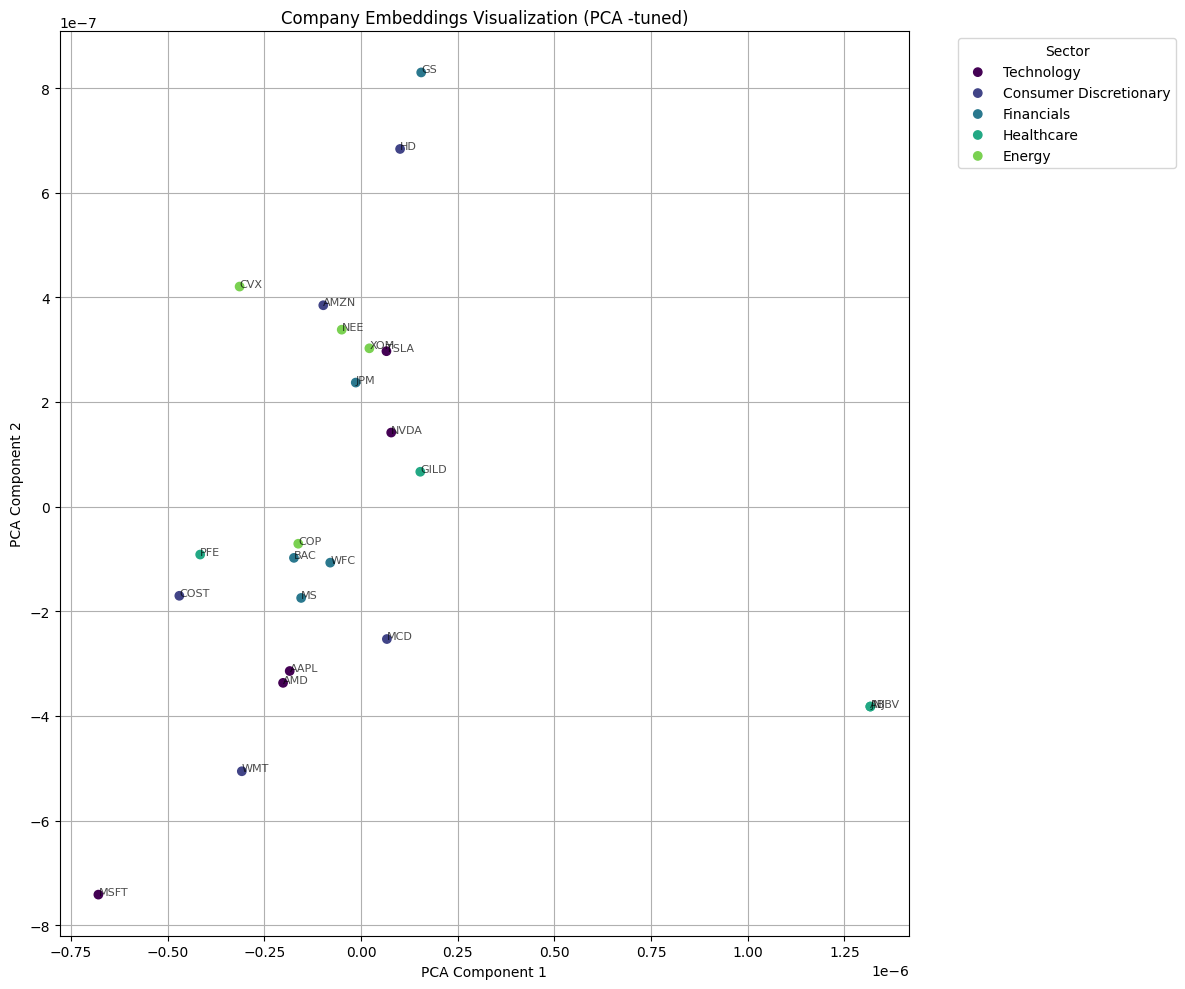

In [47]:
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Create the output directory if it doesn't exist
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

#  explicit lists of likely popular companies per sector (using tickers)
popular_companies_by_sector = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMD'],
    'Consumer Discretionary': ['AMZN', 'COST', 'WMT', 'MCD', 'HD'],
    'Financials': ['JPM', 'BAC', 'MS', 'WFC', 'GS'],
    'Healthcare': ['PFE', 'MRNA', 'JNJ', 'ABBV', 'GILD'],
    'Energy': ['XOM', 'CVX', 'NEE', 'COP', 'BP']
}

# Create a list of the top popular tickers
top_popular_tickers = []
for sector, tickers in popular_companies_by_sector.items():
    top_popular_tickers.extend(tickers)

# Filter the aggregated_df to include only these top popular tickers
selected_aggregated_df = aggregated_df[aggregated_df['ticker'].isin(top_popular_tickers)].copy()

# Create a mapping from ticker to sector
ticker_to_sector = {}
for sector, tickers in popular_companies_by_sector.items():
    for ticker in tickers:
        ticker_to_sector[ticker] = sector

# Add a 'Sector' column to selected_aggregated_df based on the mapping
selected_aggregated_df['Sector'] = selected_aggregated_df['ticker'].map(ticker_to_sector)

# Get unique sectors and create a mapping for colors
unique_sectors = list(popular_companies_by_sector.keys())
sector_to_color = {sector: plt.cm.viridis(i/len(unique_sectors)) for i, sector in enumerate(unique_sectors)}
selected_aggregated_df['color'] = selected_aggregated_df['Sector'].map(sector_to_color)

# Convert embeddings to a NumPy array
embeddings_subset = np.array(selected_aggregated_df['tuned_embedding'].tolist())

# Apply PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings_subset)
selected_aggregated_df['pca_1'] = reduced_embeddings_pca[:, 0]
selected_aggregated_df['pca_2'] = reduced_embeddings_pca[:, 1]

plt.figure(figsize=(12, 10))
for sector in popular_companies_by_sector.keys():  # Iterate through dictionary keys
    subset_df = selected_aggregated_df[selected_aggregated_df['Sector'] == sector]
    plt.scatter(subset_df['pca_1'], subset_df['pca_2'], c=subset_df['color'], label=sector)
    # Add ticker annotations
    for i, row in subset_df.iterrows():
        plt.annotate(row['ticker'], (row['pca_1'], row['pca_2']), fontsize=8, alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Company Embeddings Visualization (PCA -tuned)')
plt.grid(True)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PCA_tuned.png"))  # Save the PCA plot
plt.show()
